In [ ]:
# Import necessary libraries
import os
import gc
import torch
import pandas as pd
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils
from transformers import AutoTokenizer, AutoModelForCausalLM

# Parameters
dataset_name = 'manjuvallayil/factver_master'
model_name = 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'
llama_model_name = 'meta-llama/Llama-2-7b-chat-hf'

selected_claim_id = 'Claim_10'
similarity_threshold = 0.75  # delta for cosine similarity
alpha = 0.5  # parameter for weighted vector combination of thematic embedding
n_docs = 6  # number of docs to retrieve by RAG
n_components_carag = 3  # number of clusters for CARAG
n_components_carag_u = 10  # number of clusters for CARAG-U

# Paths for RAGUtils
passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

# Initialize LLaMA model
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
llama_model = AutoModelForCausalLM.from_pretrained(llama_model_name)

# Initialize utilities
data_utils = DataUtils(dataset_name)
model_utils = ModelUtils(model_name, embedding_model_name)
lime_utils = LIMEUtils(model_utils)
soi_utils = SOIUtils(model_utils)
rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)

# Function to generate LLM-based explanation
def generate_llm_summary(claim, evidences):
    # Clear the GPU cache first
    gc.collect()
    torch.cuda.empty_cache()
    combined_evidence = ' '.join([evidence for evidence in evidences])
    prompt = f"Claim: {claim}\nEvidence: {combined_evidence}\nYou are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max)."
    
    with torch.no_grad():
        inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
        outputs = llama_model.generate(inputs['input_ids'], max_new_tokens=200)
    
    return llama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()


"""
# Load themed data
theme, themed_data = data_utils.filter_by_theme(selected_claim_id)

# CARAG: Themed data clustering
if not themed_data.empty:
    # Get embeddings for themed data
    all_texts = [row['Claim_text'] for _, row in themed_data.iterrows()]
    for _, row in themed_data.iterrows():
        all_texts.extend(row['Evidence_text'])
    
    embeddings = model_utils.get_sent_embeddings(all_texts)
    
    # Apply GMM-EM clustering to themed data
    labels_carag = model_utils.cluster_embeddings(embeddings, n_components=n_components_carag)
    unique_labels_carag = set(labels_carag)
    print(f"Unique clusters identified within the theme {theme}: {unique_labels_carag}")

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id_carag = None
    claim_text = None

    for index, row in themed_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id_carag = labels_carag[index]
            claim_text = row['Claim_text']
            break

    if selected_cluster_id_carag is not None:
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id_carag}")

        # 1. RAG-based retrieval and explanation (AS BASELINE)
        rag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding=None, alpha=1.0)
        rag_explanation = generate_llm_summary(claim_text, rag_evidence)
        print("\nRAG Explanation:\n", rag_explanation)
        
        # 2. CARAG-based retrieval and explanation
        carag_soi = soi_utils.compute_soi(selected_claim_id, themed_data, labels_carag, selected_cluster_id_carag, similarity_threshold)
        carag_soi_evidences = carag_soi['related_claims'] + carag_soi['annotated_evidences'] + carag_soi['thematic_cluster_evidences']

        # Compute aggregated embedding for CARAG SOI
        carag_aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in carag_soi_evidences])
        
        # Retrieve evidence using CARAG's SOI-based embedding
        carag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, carag_aggregated_embedding, alpha=0.5)
        carag_explanation = generate_llm_summary(claim_text, carag_evidence)
        print("\nCARAG Explanation:\n", carag_explanation)
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster in CARAG.")

else:
    print(f"No data found for the theme of claim {selected_claim_id}.")
"""


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using the latest cached version of the dataset since manjuvallayil/factver_master couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/qsh5523/.cache/huggingface/datasets/manjuvallayil___factver_master/default/0.0.0/50f3bf76490fd2c7dfa76bb772ddabe2857e4eae (last modified on Fri Dec 20 19:40:27 2024).
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
INFO:root:Classification model loaded on CUDA
/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning:

Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may

Claim ID Claim_10 is valid and exists in the dataset.


Batches:   0%|          | 0/116 [00:00<?, ?it/s]

Unique clusters identified in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
The selected claim (Claim_10) belongs to cluster 8


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


CARAG_U Explanation:
 Claim: The EU Emisson tradding schem (ETS) was launched in 2014
Evidence: This greenhouse gas trading scheme forms part of the UK government's ambition to achieve net zero emissions by 2050.Global business is increasingly familiar with the prospect of short-notice public investigatory attention, whether from regulators, law enforcement, political forces or as a consequence of sanctions, and this can  in in some cases  devastate individual and corporate reputation. It covers just under half of all Welsh emissions (a higher proportion than any other UK nation) and raises hundreds of millions of pounds from Wales for the UK Treasury. Meanwhile, there are fears that long-term overplanting exotics could also lead to lower ETS prices, disincentivising investment and innovation in low-carbon technology and suppressing moves to make actual reductions in emissions. The UK's carbon market is supposed to reduce carriers' emissions under the polluter pays principle. Charging

In [10]:
selected_claim_id = 'Claim_59'
# CARAG-U: Dataset-wide clustering
grouped_data = data_utils.get_full_data(selected_claim_id)

if not grouped_data.empty:
    # Get embeddings for dataset-wide clustering
    all_texts = [row['Claim_text'] for _, row in grouped_data.iterrows()]
    for _, row in grouped_data.iterrows():
        all_texts.extend(row['Evidence_text'])
    
    embeddings = model_utils.get_sent_embeddings(all_texts)
    
    # Apply GMM-EM clustering to the full dataset
    labels_carag_u = model_utils.cluster_embeddings(embeddings, n_components=n_components_carag_u)
    unique_labels_carag_u = set(labels_carag_u)
    print(f"Unique clusters identified in the dataset: {unique_labels_carag_u}")

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id_carag_u = None
    claim_text = None

    for index, row in grouped_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id_carag_u = labels_carag_u[index]
            claim_text = row['Claim_text']
            break

    if selected_cluster_id_carag_u is not None:
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id_carag_u}")

        # 3. CARAG-U-based retrieval and explanation
        carag_u_soi = soi_utils.compute_soi_carag_u(selected_claim_id, grouped_data, labels_carag_u, selected_cluster_id_carag_u, similarity_threshold)
        carag_u_soi_evidences = carag_u_soi['refined_cluster_evidences']

        # Compute aggregated embedding for CARAG-U SOI
        carag_u_aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in carag_u_soi_evidences])
        
        # Retrieve evidence using CARAG-U's dataset-wide embedding
        carag_u_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, carag_u_aggregated_embedding, alpha=0.5)
        carag_u_explanation = generate_llm_summary(claim_text, carag_u_evidence)
        print("\nCARAG_U Explanation:\n", carag_u_explanation)
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster in CARAG-U.")

else:
    print("No data found in the dataset.")

Claim ID Claim_59 is valid and exists in the dataset.


Batches:   0%|          | 0/116 [00:00<?, ?it/s]

Unique clusters identified in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
The selected claim (Claim_59) belongs to cluster 8


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


CARAG_U Explanation:
 Claim: The public is unconcerned about a climate emergency
Evidence: Failure will result in the country's once-successful car making industry being largely consigned to the scrap heap. This greenhouse gas trading scheme forms part of the UK government's ambition to achieve net zero emissions by 2050.Global business is increasingly familiar with the prospect of short-notice public investigatory attention, whether from regulators, law enforcement, political forces or as a consequence of sanctions, and this can  in in some cases  devastate individual and corporate reputation. Cho Tae-yong, ambassador of the Republic of Korea to the U.S., said Tuesday officials are discussing “several possible options” to correct what the country believes to be unfair policies that eliminated up to $7,500 of tax credits for EVs produced outside North America. They could drive back to Israel and get a ferry around the middle east to Qatar - but that is a two-week journey which would h

In [17]:
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils

# Parameters
#embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'

# Paths for RAGUtils
#passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
#index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

import numpy as np
import pandas as pd

# Initialize utilities
#rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)


# Load dataset and global vectors
dataset_vectors = rag_utils.load_dataset_vectors()  # Global context vectors
print(f"Loaded {len(dataset_vectors)} vectors from the FAISS index.")

# Load the data from the CSV file
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes in results.csv
themes = df['Theme'].unique() if 'Theme' in df.columns else []
print(f"Available themes in results.csv: {themes}")

# Step 1: Extract claim IDs and explanations
# Uncomment the line below to filter for a specific theme (e.g., Climate, Covid, Electric_Vehicles)
df = df[df['Theme'] == 'Climate']
claim_ids = df['Claim_id'].tolist()
annotated_explanations = df['Annotated'].tolist()
rag_explanations = df['RAG'].tolist()
carag_explanations = df['CARAG'].tolist()
carag_u_explanations = df['CARAG_U'].tolist()  # New column for CARAG_U explanations

# Define function for generating embeddings
def generate_explanation_embeddings(explanations, model_utils):
    explanation_embeddings = model_utils.get_sent_embeddings(explanations)
    return np.atleast_2d(explanation_embeddings)  # Ensure the embeddings are 2D

# Generate embeddings for explanations
annotated_embeddings = generate_explanation_embeddings(annotated_explanations, model_utils)
rag_embeddings = generate_explanation_embeddings(rag_explanations, model_utils)
carag_embeddings = generate_explanation_embeddings(carag_explanations, model_utils)
carag_u_embeddings = generate_explanation_embeddings(carag_u_explanations, model_utils)  # Generate CARAG_U embeddings

# Generate themed data embeddings for each theme
themed_data_embeddings = {}
for theme in themes:
    themed_data = data_utils.themed_data(theme)
    if not themed_data.empty:
        # Flatten list of lists in `Evidence_text`
        valid_evidence_texts = themed_data['Evidence_text'].dropna().tolist()
        valid_evidence_texts_flat = [item for sublist in valid_evidence_texts for item in sublist if isinstance(item, str) and item.strip()]
        
        # Generate embeddings if valid evidence texts exist
        if valid_evidence_texts_flat:
            themed_vectors = model_utils.get_sent_embeddings(valid_evidence_texts_flat)
            themed_data_embeddings[theme] = themed_vectors
            print(f"Generated embeddings for theme '{theme}' with {len(themed_vectors)} vectors.")
        else:
            print(f"No valid evidence texts found for theme '{theme}'.")
    else:
        print(f"No data found for theme '{theme}'")

# Print CARAG_U embeddings for verification
print(f"Generated {len(carag_u_embeddings)} CARAG_U embeddings.")

Loaded 3102 vectors from the FAISS index.
Available themes in results.csv: ['Climate' 'Covid' 'Electric_Vehicles']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Generated embeddings for theme 'Climate' with 486 vectors.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Generated embeddings for theme 'Covid' with 2004 vectors.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generated embeddings for theme 'Electric_Vehicles' with 606 vectors.
Generated 10 CARAG_U embeddings.


/tmp/ipykernel_1560166/3946660021.py:80: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/tmp/ipykernel_1560166/3946660021.py:100: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



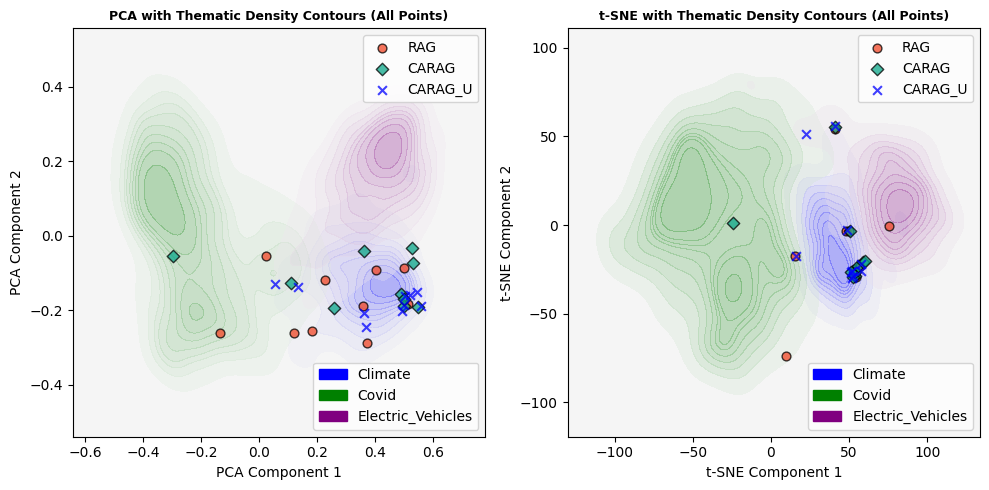

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Function to apply t-SNE
def apply_tsne(embeddings):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(embeddings)

# Apply PCA and t-SNE transformations to RAG, CARAG, CARAG_U, and themed embeddings
all_embeddings = np.vstack([rag_embeddings, carag_embeddings, carag_u_embeddings, *themed_data_embeddings.values()])
labels = (
    ['RAG'] * len(rag_embeddings)
    + ['CARAG'] * len(carag_embeddings)
    + ['CARAG_U'] * len(carag_u_embeddings)
    + sum([[theme] * len(vectors) for theme, vectors in themed_data_embeddings.items()], [])
)

# PCA transformation
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation
tsne_embeddings = apply_tsne(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_tsne = tsne_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Define distinct colors for each theme and approach
theme_colors = {
    'Climate': 'blue',
    'Covid': 'green',
    'Electric_Vehicles': 'purple'
}
approach_colors = {
    'RAG': '#F24726',  # Red
    'CARAG': '#0CA789',  # Teal
    'CARAG_U': 'blue'  # Blue
}

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) #figsize=(8, 4.25)

# PCA plot with separate thematic densities
for theme, color in theme_colors.items():
    if themed_pca[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_pca[theme][:, 0],
            y=themed_pca[theme][:, 1],
            ax=axes[0],
            fill=True,
            cmap=sns.light_palette(color, as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
axes[0].scatter(rag_pca[:, 0], rag_pca[:, 1], color=approach_colors['RAG'], edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[0].scatter(carag_pca[:, 0], carag_pca[:, 1], color=approach_colors['CARAG'], edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[0].scatter(carag_u_pca[:, 0], carag_u_pca[:, 1], color=approach_colors['CARAG_U'], edgecolor='black', label='CARAG_U', s=40, marker='x', alpha=0.75)
axes[0].set_title("PCA with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')

# t-SNE plot with separate thematic densities
for theme, color in theme_colors.items():
    if themed_tsne[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_tsne[theme][:, 0],
            y=themed_tsne[theme][:, 1],
            ax=axes[1],
            fill=True,
            cmap=sns.light_palette(color, as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
axes[1].scatter(rag_tsne[:, 0], rag_tsne[:, 1], color=approach_colors['RAG'], edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[1].scatter(carag_tsne[:, 0], carag_tsne[:, 1], color=approach_colors['CARAG'], edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[1].scatter(carag_u_tsne[:, 0], carag_u_tsne[:, 1], color=approach_colors['CARAG_U'], edgecolor='black', label='CARAG_U', s=40, marker='x', alpha=0.75)
axes[1].set_title("t-SNE with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Add the first legend for scatter plot points
handles_points, labels_points = axes[0].get_legend_handles_labels()
scatter_legend = axes[0].legend(handles=handles_points, labels=labels_points, loc='upper right')#, title='Approaches'

# Add the second legend for thematic contours
theme_legend_patches = [mpatches.Patch(color=color, label=f"{theme}") for theme, color in theme_colors.items()]
contour_legend = axes[0].legend(handles=theme_legend_patches, loc='lower right')#, title='Thematic Contours'

# Add legends back manually
axes[0].add_artist(scatter_legend)

handles_points_tsne, labels_points_tsne = axes[1].get_legend_handles_labels()
scatter_legend_tsne = axes[1].legend(handles=handles_points_tsne, labels=labels_points_tsne, loc='upper right')#, title='Approaches'

contour_legend_tsne = axes[1].legend(handles=theme_legend_patches, loc='lower right')#, title='Thematic Contours'
axes[1].add_artist(scatter_legend_tsne)

plt.tight_layout()
plt.show()

In [22]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from IPython.display import display

# Load the data from results.csv
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Debugging: Print dimensions of the arrays
print(f"DataFrame rows: {len(df)}")
print(f"rag_pca size: {rag_pca.shape[0]}, carag_pca size: {carag_pca.shape[0]}, carag_u_pca size: {carag_u_pca.shape[0]}")

# Check for available themes and exclude `nan`
themes = [theme for theme in df['Theme'].unique() if pd.notna(theme)]
print(f"Available themes in results.csv (excluding nan): {themes}")

# Filter RAG, CARAG, and CARAG_U points by theme from the CSV file
rag_points = {}
carag_points = {}
carag_u_points = {}

for theme in themes:
    indices = df[df['Theme'] == theme].index
    valid_indices = indices[indices < rag_pca.shape[0]]  # Ensure indices are within bounds
    
    rag_points[theme] = rag_pca[np.array(valid_indices)]
    carag_points[theme] = carag_pca[np.array(valid_indices)]
    carag_u_points[theme] = carag_u_pca[np.array(valid_indices)]

    # Debugging: Print shapes of filtered data
    print(f"Theme '{theme}': {len(valid_indices)} points")

# Step 1: Calculate the centroids of each theme contour
theme_centroids_pca = {theme: np.mean(themed_pca[theme], axis=0) for theme in themes}
theme_centroids_tsne = {theme: np.mean(themed_tsne[theme], axis=0) for theme in themes}

# Step 2: Calculate distances of RAG points to theme centroids (PCA and t-SNE)
rag_distances_pca = {theme: cdist(rag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
rag_distances_tsne = {theme: cdist(rag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 3: Calculate distances of CARAG and CARAG_U points to theme centroids (PCA and t-SNE)
carag_distances_pca = {theme: cdist(carag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_distances_tsne = {theme: cdist(carag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}
carag_u_distances_pca = {theme: cdist(carag_u_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_u_distances_tsne = {theme: cdist(carag_u_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 4: Prepare DataFrames for RAG, CARAG, and CARAG_U distances with difference columns
theme_tables = {}
for theme in themes:
    theme_table = []
    for i in range(len(rag_distances_pca[theme])):
        theme_table.append({
            "Theme": theme,
            "Point Index": i,
            "RAG Distance (PCA)": rag_distances_pca[theme][i],
            "CARAG Distance (PCA)": carag_distances_pca[theme][i],
            "CARAG_U Distance (PCA)": carag_u_distances_pca[theme][i],
            "Difference (PCA - CARAG)": carag_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "Difference (PCA - CARAG_U)": carag_u_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "RAG Distance (t-SNE)": rag_distances_tsne[theme][i],
            "CARAG Distance (t-SNE)": carag_distances_tsne[theme][i],
            "CARAG_U Distance (t-SNE)": carag_u_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG)": carag_distances_tsne[theme][i] - rag_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG_U)": carag_u_distances_tsne[theme][i] - rag_distances_tsne[theme][i]
        })
    
    # Convert to DataFrame
    table_df = pd.DataFrame(theme_table)
    
    # Calculate averages for each numeric column
    averages = table_df.mean(numeric_only=True).to_dict()
    averages["Theme"] = f"{theme} - Average"
    averages["Point Index"] = "N/A"
    
    # Append averages as the last row using pd.concat
    average_row_df = pd.DataFrame([averages])
    table_df = pd.concat([table_df, average_row_df], ignore_index=True)
    
    theme_tables[theme] = table_df

# Display theme-specific tables with average rows
for theme, table in theme_tables.items():
    print(f"\nEuclidean Distance Table for Theme: {theme}")
    display(table)

# Step 5: Prepare a combined alignment comparison table
alignment_comparison = []
for theme in themes:
    rag_avg_distance_pca = np.mean(rag_distances_pca[theme])
    carag_avg_distance_pca = np.mean(carag_distances_pca[theme])
    carag_u_avg_distance_pca = np.mean(carag_u_distances_pca[theme])
    rag_avg_distance_tsne = np.mean(rag_distances_tsne[theme])
    carag_avg_distance_tsne = np.mean(carag_distances_tsne[theme])
    carag_u_avg_distance_tsne = np.mean(carag_u_distances_tsne[theme])

    alignment_comparison.append({
        "Theme": theme,
        "RAG Avg Distance (PCA)": rag_avg_distance_pca,
        "CARAG Avg Distance (PCA)": carag_avg_distance_pca,
        "CARAG_U Avg Distance (PCA)": carag_u_avg_distance_pca,
        "Difference (PCA - CARAG)": carag_avg_distance_pca - rag_avg_distance_pca,
        "Difference (PCA - CARAG_U)": carag_u_avg_distance_pca - rag_avg_distance_pca,
        "RAG Avg Distance (t-SNE)": rag_avg_distance_tsne,
        "CARAG Avg Distance (t-SNE)": carag_avg_distance_tsne,
        "CARAG_U Avg Distance (t-SNE)": carag_u_avg_distance_tsne,
        "Difference (t-SNE - CARAG)": carag_avg_distance_tsne - rag_avg_distance_tsne,
        "Difference (t-SNE - CARAG_U)": carag_u_avg_distance_tsne - rag_avg_distance_tsne,
        "Better Alignment (PCA)": "CARAG_U" if carag_u_avg_distance_pca < min(carag_avg_distance_pca, rag_avg_distance_pca) else 
                                   ("CARAG" if carag_avg_distance_pca < rag_avg_distance_pca else "RAG"),
        "Better Alignment (t-SNE)": "CARAG_U" if carag_u_avg_distance_tsne < min(carag_avg_distance_tsne, rag_avg_distance_tsne) else 
                                     ("CARAG" if carag_avg_distance_tsne < rag_avg_distance_tsne else "RAG")
    })

# Convert alignment comparison to a DataFrame
alignment_df = pd.DataFrame(alignment_comparison)

# Add an average row for the combined table using pd.concat
average_row = alignment_df.mean(numeric_only=True).to_dict()
average_row["Theme"] = "Overall Average"
average_row_df = pd.DataFrame([average_row])
alignment_df = pd.concat([alignment_df, average_row_df], ignore_index=True)

# Display the combined alignment comparison table with average row
print("\nCombined Alignment Comparison Table:")
display(alignment_df)

DataFrame rows: 30
rag_pca size: 10, carag_pca size: 10, carag_u_pca size: 10
Available themes in results.csv (excluding nan): ['Climate', 'Covid', 'Electric_Vehicles']
Theme 'Climate': 10 points
Theme 'Covid': 0 points
Theme 'Electric_Vehicles': 0 points

Euclidean Distance Table for Theme: Climate


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Climate,0,0.061851,0.665073,0.309724,0.603222,0.247873,41.140848,41.808886,41.449815,0.668038,0.308967
1,Climate,1,0.222125,0.127513,0.142436,-0.094612,-0.079689,41.293671,41.023116,41.008193,-0.270554,-0.285478
2,Climate,2,0.051717,0.149281,0.160516,0.097565,0.108800,41.121678,41.003792,40.990257,-0.117886,-0.131421
3,Climate,3,0.160924,0.252127,0.150141,0.091203,-0.010783,41.103190,41.394681,41.006419,0.291491,-0.096771
4,Climate,4,0.160309,0.142736,0.180535,-0.017573,0.020225,40.991219,41.008144,40.971248,0.016925,-0.019971
5,Climate,5,0.137371,0.084057,0.080163,-0.053314,-0.057208,41.285500,41.175264,41.134180,-0.110236,-0.151320
6,Climate,6,0.279239,0.193567,0.204452,-0.085672,-0.074787,41.353541,40.957807,40.946466,-0.395735,-0.407075
7,Climate,7,0.347147,0.187185,0.119633,-0.159962,-0.227514,41.497517,41.016359,41.115079,-0.481158,-0.382438
8,Climate,8,0.516726,0.126320,0.230557,-0.390406,-0.286169,41.601102,41.236543,41.370972,-0.364559,-0.230130
9,Climate,9,0.140001,0.175157,0.147828,0.035156,0.007827,41.031074,41.002384,41.004850,-0.028690,-0.026224



Euclidean Distance Table for Theme: Covid


,Theme,Point Index
0,Covid - Average,N/A



Euclidean Distance Table for Theme: Electric_Vehicles


,Theme,Point Index
0,Electric_Vehicles - Average,N/A



Combined Alignment Comparison Table:


/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



,Theme,RAG Avg Distance (PCA),CARAG Avg Distance (PCA),CARAG_U Avg Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Avg Distance (t-SNE),CARAG Avg Distance (t-SNE),CARAG_U Avg Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U),Better Alignment (PCA),Better Alignment (t-SNE)
0,Climate,0.207741,0.210302,0.172599,0.002561,-0.035142,41.241934,41.162698,41.099748,-0.079236,-0.142186,CARAG_U,CARAG_U
1,Covid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RAG,RAG
2,Electric_Vehicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RAG,RAG
3,Overall Average,0.207741,0.210302,0.172599,0.002561,-0.035142,41.241934,41.162698,41.099748,-0.079236,-0.142186,NaN,NaN


# TRY 3D VISUALIZATIONS and DYNAMIC CLUSTERING

• Unsupervised Thematic Clustering  Use clustering techniques (e.g., GMM-EM) on the entire dataset embeddings to dynamically discover thematic clusters.  Cluster size (k) can be:  • Fixed by the user (e.g., 10 clusters by default).  

• Dynamically determined using methods like silhouette score or Bayesian Information Criterion (BIC).  Ensure clusters group semantically related texts, irrespective of labels or themes.  